## Brain MRI Segmentation with Unet | TensorFlow

### [Kaggle Dataset](https://www.kaggle.com/code/monkira/brain-mri-segmentation-using-unet-keras/notebook)

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2022-04-28 04:37:13.888372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/paul/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-28 04:37:13.888396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
#Set Parameters
im_width = 256
im_height = 256


# **Load image's path and mask's path**

Note, for each .tif MR image there is a corresponding mask image. So in below, I am defining two list one containing all the .tif MR images, and the other for all the mask images.

In [4]:
image_filenames_train = []

# creating a list of all files containing the word 'mask'
# in Local Machine
# mask_files = glob('../../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# in Kaggle
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)




['../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_18.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_9.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_5.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_26.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_29.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_39.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_25.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_16.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_23.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_21.tif']


3929

## Plot some images and masks

In [5]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows*columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()
        

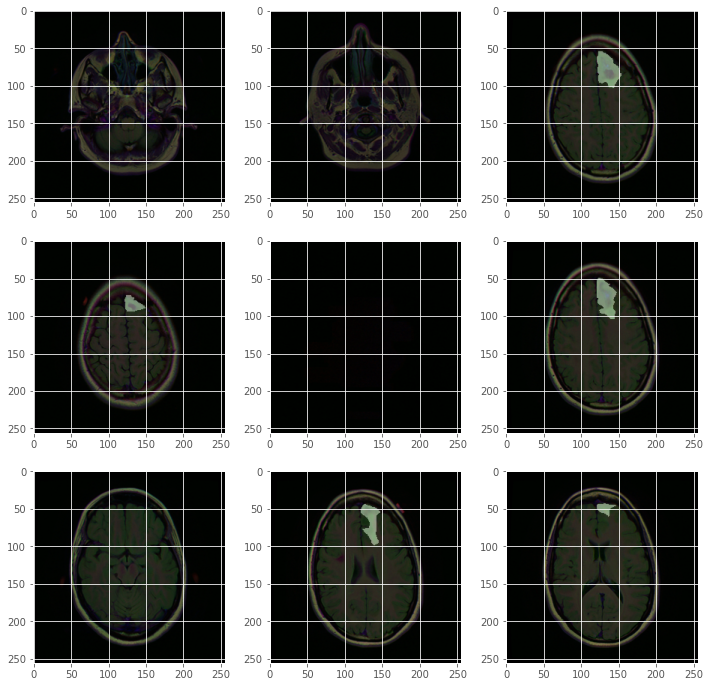

In [6]:
plot_from_img_path(3, 3, image_filenames_train, mask_files)

# **Create data frame and split data on train set, validation set and test set**

In [7]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size = 0.1)

# Further split the df_train
df_train, df_val = train_test_split(df_train, test_size = 0.2)

print('df_train.shape', df_train.values.shape)
print('df_test.shape', df_test.values.shape)
print('df_val.shape', df_val.values.shape)

df_train.shape (2828, 2)
df_test.shape (393, 2)
df_val.shape (708, 2)


# **Data genertator, data augmentation and adjust data**

In [8]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)
    
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

## Parameter for `flow_from_dataframe`

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe


```py
flow_from_dataframe(
    dataframe,
    directory=None,
    x_col="filename",
    y_col="class",
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    drop_duplicates=True,
)

```

### dataframe and directory

In this, you need to provide the data frame that contains the image names or file paths and the corresponding labels. Now, there are two cases possible:

https://theailearner.com/2019/07/06/imagedatagenerator-flow_from_dataframe-method/

if the data frame contains image names then you need to specify the directory where these images are residing, using the “directory” argument. See the example below.
if the data frame contains the absolute image paths then set the “directory” argument to None.



### class_mode

Will take one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical". Mode for yielding the targets:
  
**None** means no targets are returned (the generator will only yield batches of image data, which is useful to use in `model.predict()`.

Similarly, for the labels column, the values can be string/list/tuple depending on the “class_mode” argument. For instance, if class_mode is binary, then the label column must contain the class values as strings. Note that we can have multiple label columns also. For instance regression tasks like bounding box prediction etc. Then you need to pass these columns as a list in the “y_col” argument.


### color_mode

one of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1 or 3 color channels.

### target_size	

Tuple of integers (height, width), default: (256, 256). The dimensions to which all images found will be resized.

### save_prefix	

str. Prefix to use for filenames of saved pictures (only relevant if save_to_dir is set).

### Read Further 

https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

# **Define loss function and metrics**

In [9]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coefficients_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

## Reason for multiplying for calculation intersection

Intersection = K.sum(y_true * y_pred) => We multiply here since multiplication will yield 1 only if both the predictions and the ground truth have 1s on a certain position... 0x1 or 1x0 or 0x0 of course do not belong to intersection.


## Reason for negative sign in dice_coefficients_loss

First note when dice_coeff is high that means high accuracy in the prediction. So Loss will be some quantity that will be high when the accuracy is low. And thats why we take the negative of that. 

And later in U-Net implementations I will using a Loss that is supposed to be minimized by training. So thats another way to understand why we take the negative, because, when we are minimizing the negative term (which is the Loss) that means we are maximizing the Accuracy.

```
model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coef])

```
Sreeni - https://youtu.be/BNPW1mYbgS4?t=261

# Unet Architecture

![Imgur](https://imgur.com/zsXIUr0.png)

In [10]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    ''' Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. '''
    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    ''' After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output '''
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

### filters: Is an Integer, which represents the dimensionality of the output space (i.e. the number of output filters in the convolution).

---

https://stackoverflow.com/questions/67439067/what-does-the-filter-parameter-mean-in-conv2d-layer

The filters argument sets the number of convolutional filters in that layer. Another way to put it, Filters are the number of features you want to detect in the image. It is a hyper-parameter and entirely up to you.

In [11]:
model = unet()
model.summary()

2022-04-28 04:37:17.160489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 04:37:17.161039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/paul/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-28 04:37:17.161228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/paul/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-28 04:37:17.161388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublas

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

# **Training**

In [12]:
# EPOCHS = 150
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

In [13]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

/home/paul/.local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/150


2022-04-28 04:37:39.364403: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1073741824 exceeds 10% of free system memory.
2022-04-28 04:37:45.963375: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1073741824 exceeds 10% of free system memory.


https://www.tensorflow.org/guide/keras/train_and_evaluate

List of metrics to be evaluated by the model during training and testing. The metrics argument should be a list -- your model can have any number of metrics.

## `tf.keras.callbacks.History()`

This callback is automatically applied to every Keras model. The History object gets returned by the fit method of models.

In [ ]:
# to list all data in history.
# print(history.history)
import pprint
pprint.pprint(history.history)

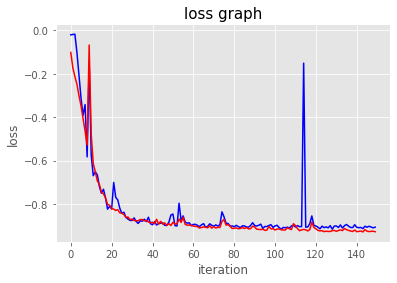

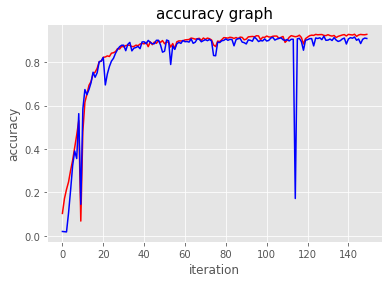

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficient']
test_dice_coeff_list = history_post_training['val_dice_coefficient']

train_jaccard_list = history_post_training['iou']

test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'r-')
plt.plot(test_dice_coeff_list, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [ ]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
13/12 [===============================] - 6s 485ms/step - loss: -0.8920 - binary_accuracy: 0.9977 - iou: 0.8071 - dice_coef: 0.8922
Test lost:  -0.891990065574646
Test IOU:  0.9976896643638611
Test Dice Coefficent:  0.8070671558380127


### np.newaxis

https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it

Simply put, [`numpy.newaxis`][1] is used to ***increase the dimension*** of the existing array by *one more dimension*, when used *once*. Thus,
 
- **1D** array will become **2D** array

- **2D** array will become **3D** array

- **3D** array will become **4D** array

- **4D** array will become **5D** array

and so on.. 

Here is a visual illustration which depicts *promotion* of 1D array to 2D arrays.

![](2022-04-28-18-00-47.png)

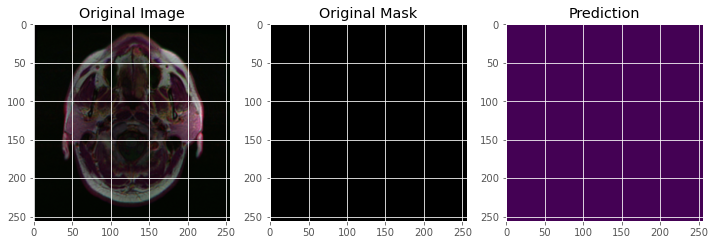

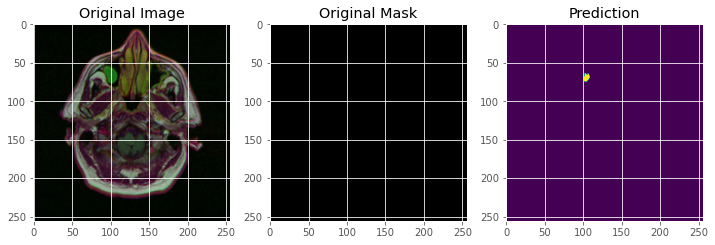

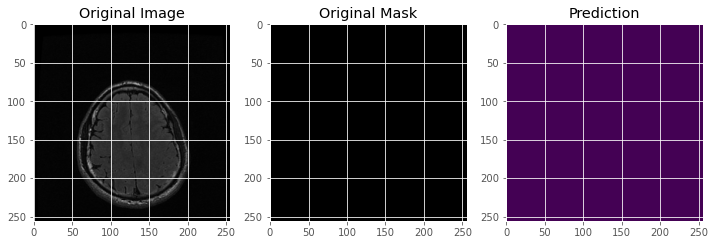

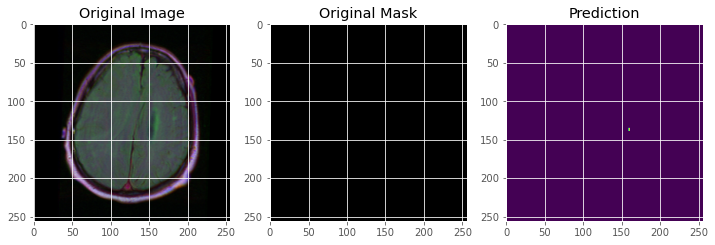

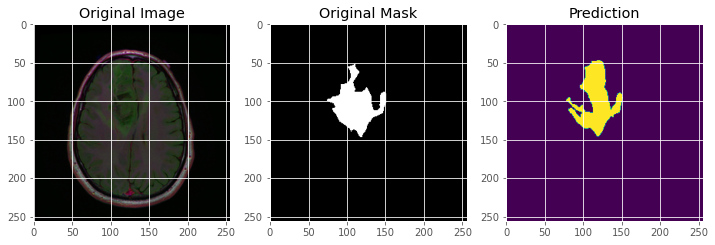

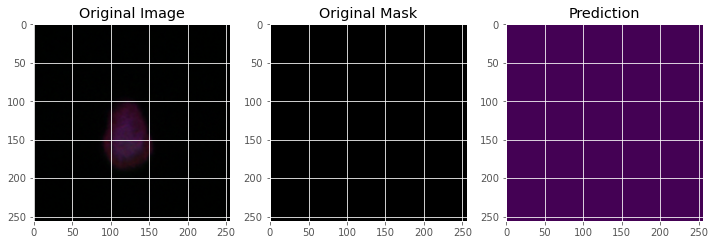

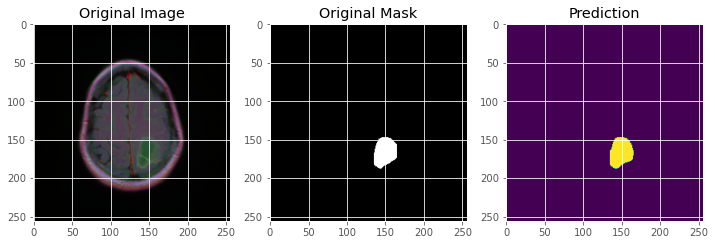

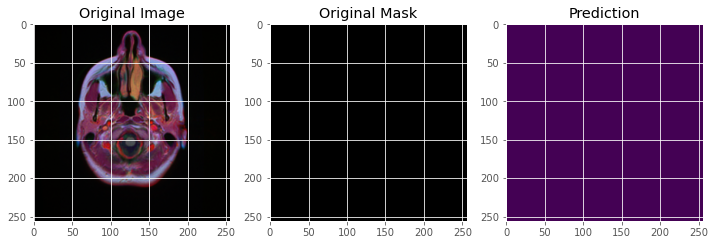

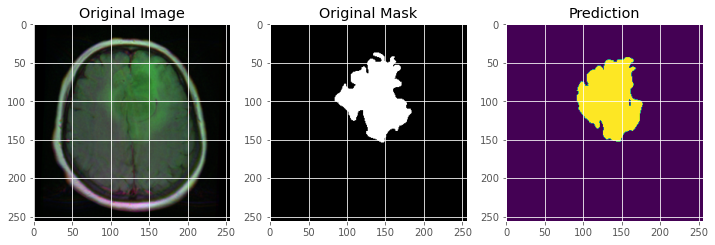

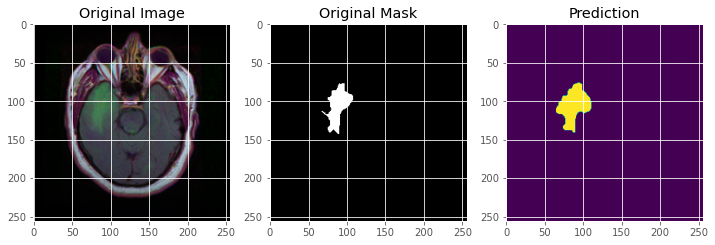

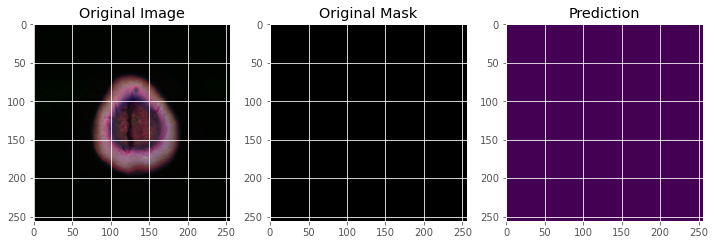

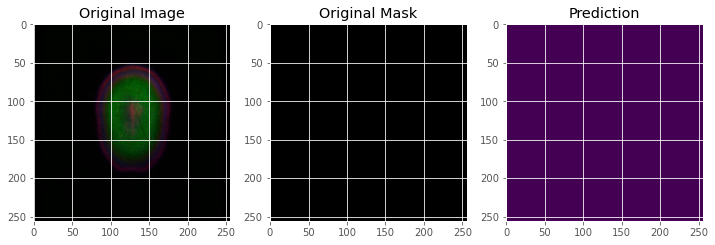

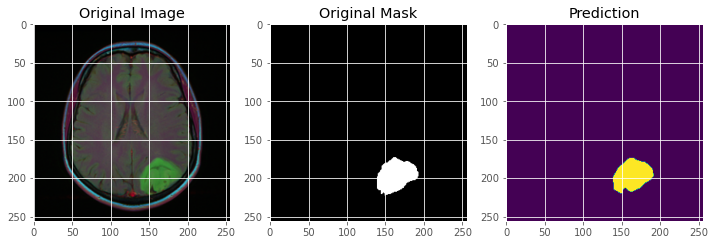

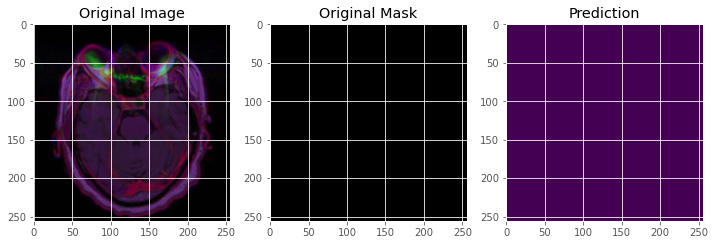

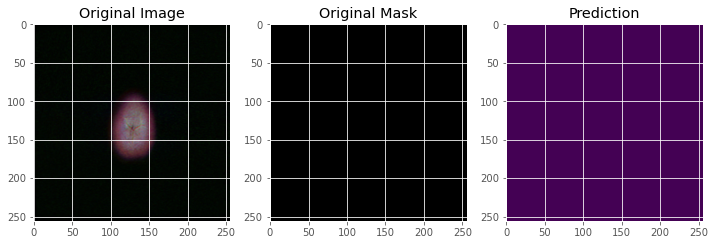

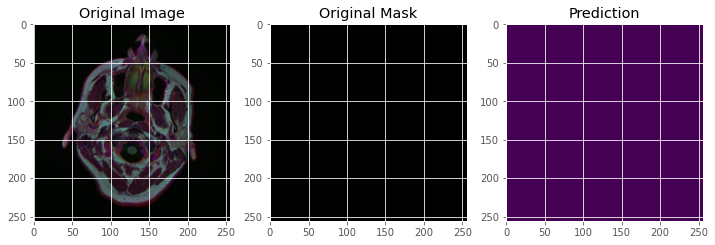

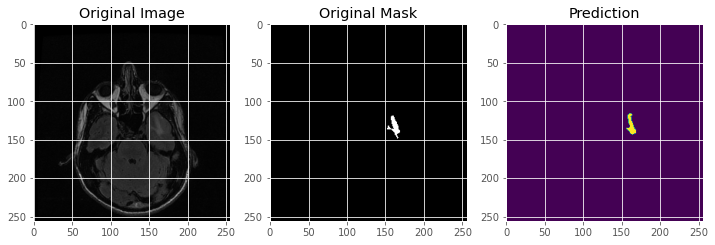

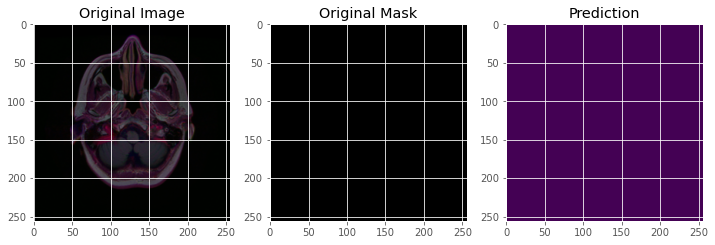

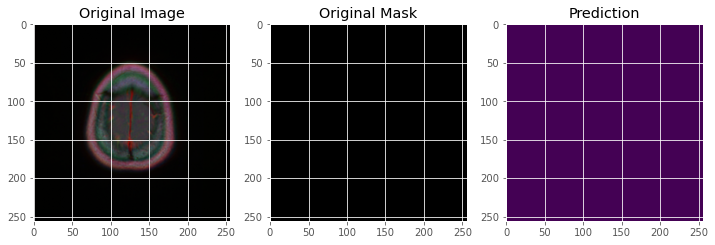

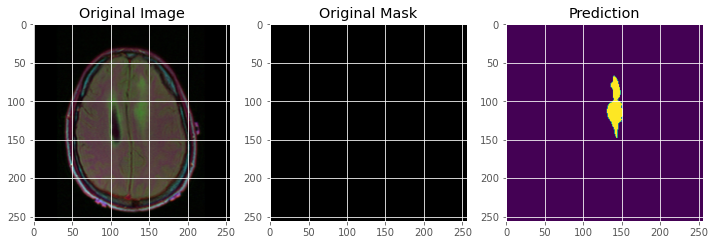

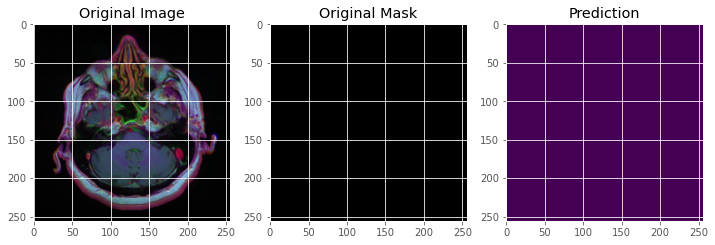

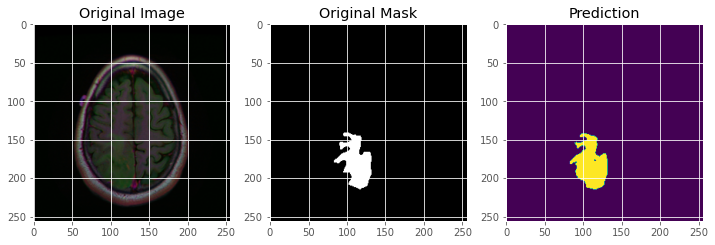

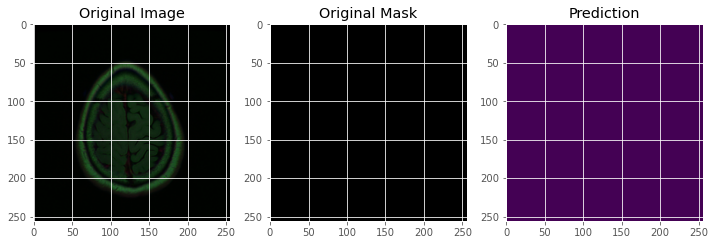

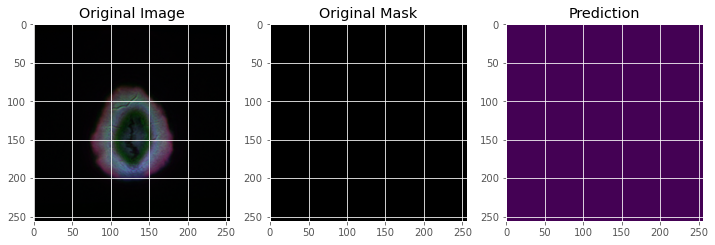

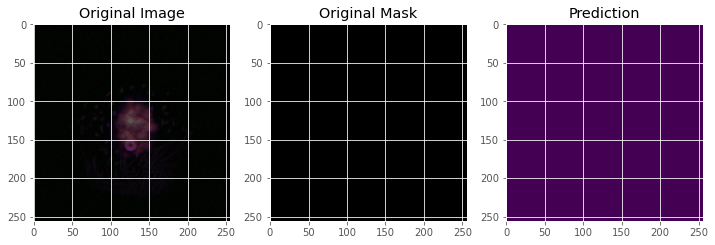

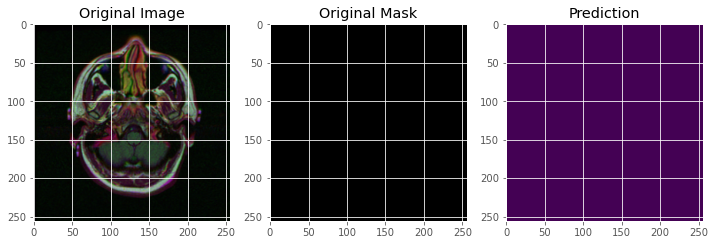

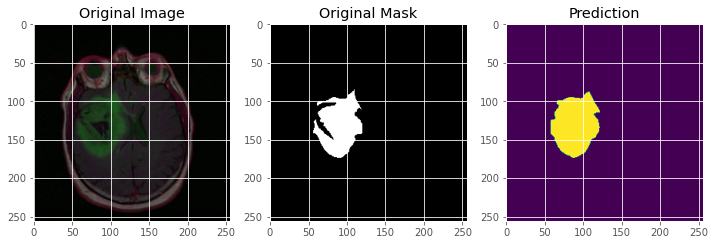

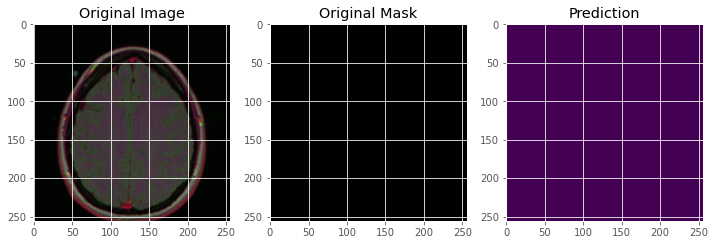

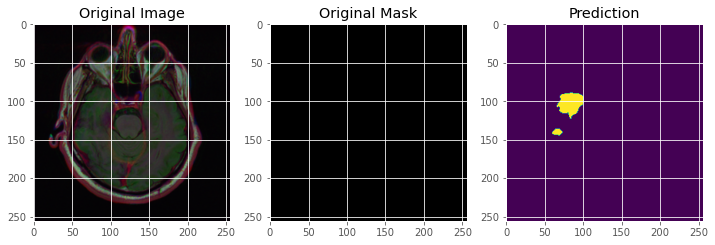

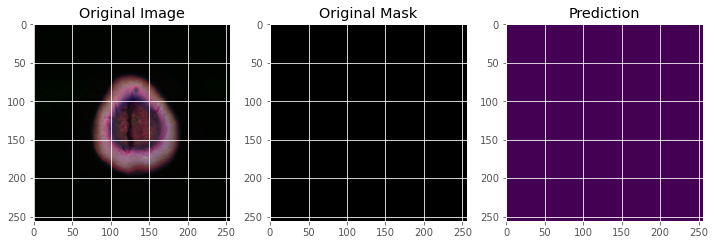

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    # print(img.shape) # (256, 256, 3)
    # Hence need to convert the above 3-D Tensor to a 4-D Tensor
    img = img[np.newaxis, :, :, :]
    # print('After newaxis ', img.shape) # (1, 256, 256, 3)
    
    # Now get the Predicted Image from the Model given the Orignal Image
    predicted_img = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(predicted_img) > .5)
    plt.title('Prediction')
    plt.show()